In [ ]:
# Set path to constraints directory
from shared_utils import setup_paths

notebook_dir, constraints_dir, PATH = setup_paths()

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ast
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.spatial.distance import cdist

In [28]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier with 3 base learners
model = RandomForestClassifier(n_estimators=3, random_state=42)
model.fit(X_train, y_train)

,n_estimators,3
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
X_test[0]

array([6.1, 2.8, 4.7, 1.2])

In [30]:
# Using classical constraints
with open(PATH + "iris_l3_pv0.001_t2_dpg_metrics.txt", 'r') as file:
    lines = file.readlines()

constraints_source = lines[1]
constraints_source


"Class Bounds: {'Class 0': ['petal width (cm) <= 1.65', 'petal length (cm) <= 2.45'], 'Class 1': ['0.8 < petal width (cm) <= 1.75', '2.45 < petal length (cm) <= 5.35', 'sepal length (cm) <= 6.05', 'sepal width (cm) > 2.75'], 'Class 2': ['0.8 < petal width (cm) <= 1.75', '2.45 < petal length (cm) <= 5.35', 'sepal length (cm) > 6.05', 'sepal width (cm) <= 3.1']}\n"

In [31]:
import ast
import re

def parse_condition(condition):
    """Parse a single condition string into a list of dictionaries with feature, operator, and value."""
    # Split by logical operators while ignoring the first part if it's a standalone number
    parts = re.split(r" (<=|>=|<|>|==) ", condition.strip())

    if len(parts) == 3:
        # Simple case: single comparison
        feature, operator, value = parts
        return [{"feature": feature.strip(), "operator": operator, "value": float(value.strip())}]
    elif len(parts) == 5:
        # Complex case: range comparison
        value1, operator1, feature, operator2, value2 = parts
        return [
            {"feature": feature.strip(), "operator": operator1, "value": float(value1.strip())},
            {"feature": feature.strip(), "operator": operator2, "value": float(value2.strip())}
        ]
    else:
        # In case of an unexpected format, return None
        return None

def constraints_v1_to_dict(raw_string):
    # Remove the prefix and newline character from the string
    stripped_string = raw_string.replace("Class Bounds: ", "").strip()

    # Use ast.literal_eval to safely parse the string into a dictionary
    parsed_dict = ast.literal_eval(stripped_string)

    # Create the nested dictionary with parsed conditions
    nested_dict = {}
    for class_name, conditions in parsed_dict.items():
        nested_conditions = []
        for condition in conditions:
            # Parse each condition into a list of dictionaries of feature, operator, and value
            parsed_conditions = parse_condition(condition)
            if parsed_conditions:
                nested_conditions.extend(parsed_conditions)
        nested_dict[class_name] = nested_conditions

    return nested_dict

def transform_by_feature(nested_dict):
    feature_dict = {}

    # Iterate through each class and its conditions
    for class_name, conditions in nested_dict.items():
        for condition in conditions:
            feature = condition["feature"]
            if feature not in feature_dict:
                feature_dict[feature] = []
            # Append the condition along with the class it belongs to
            feature_dict[feature].append({"class": class_name, "operator": condition["operator"], "value": condition["value"]})

    return feature_dict

def get_intervals_by_feature(feature_based_dict):
    feature_intervals = {}

    for feature, conditions in feature_based_dict.items():
        # Initialize intervals
        lower_bound = float('-inf')
        upper_bound = float('inf')

        # Check each condition and update the bounds
        for condition in conditions:
            operator = condition["operator"]
            value = condition["value"]

            if operator == "<":
                upper_bound = min(upper_bound, value)
            elif operator == "<=":
                upper_bound = min(upper_bound, value)
            elif operator == ">":
                lower_bound = max(lower_bound, value)
            elif operator == ">=":
                lower_bound = max(lower_bound, value)

        # Store the interval for this feature
        feature_intervals[feature] = (lower_bound, upper_bound)

    return feature_intervals

def is_value_valid_for_class(class_name, feature, value, nested_dict):
    # Get the conditions for the given class
    conditions = nested_dict.get(class_name, [])

    # Iterate through each condition for the specified feature
    for condition in conditions:
        if condition["feature"] == feature:
            operator = condition["operator"]
            comparison_value = condition["value"]

            # Check if the value satisfies the condition
            if operator == "<" and not (value < comparison_value):
                return False
            elif operator == "<=" and not (value <= comparison_value):
                return False
            elif operator == ">" and not (value > comparison_value):
                return False
            elif operator == ">=" and not (value >= comparison_value):
                return False

    # If all conditions are satisfied, return True
    return True

# Example usage
constraints = constraints_v1_to_dict(constraints_source)
validity = is_value_valid_for_class("Class 1", "petal width (cm)", 0.5, constraints)
validity


True

In [32]:
import json

def read_constraints_from_file(filename):
    constraints_dict = {}
    with open(filename, 'r') as file:
        for line in file:
            # Remove new line characters and any leading/trailing whitespace
            line = line.strip()
            if not line:
                continue

            # Split the line at the first colon to separate the class label from the JSON data
            class_label, json_string = line.split(":", 1)

            # Clean up json_string by replacing single quotes with double quotes to make it valid JSON
            json_string = json_string.strip().replace("'", '"').replace("None", "null")

            try:
                # Convert the JSON string into a Python dictionary
                constraints_dict[class_label.strip()] = json.loads(json_string)
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON for {class_label}: {e}")

    return constraints_dict

constraints = read_constraints_from_file(PATH + "custom_l100_pv0.001_t2_dpg_metrics.txt")
print(constraints)

{'Class 0': [{'feature': 'petal_length', 'min': None, 'max': 5.05}, {'feature': 'petal_width', 'min': None, 'max': 1.75}, {'feature': 'sepal_length', 'min': 5.15, 'max': 6.15}, {'feature': 'sepal_width', 'min': 2.8, 'max': 3.25}], 'Class 1': [{'feature': 'petal_length', 'min': 2.15, 'max': 5.45}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 7.1}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.7}], 'Class 2': [{'feature': 'petal_length', 'min': 2.35, 'max': 5.25}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 6.75}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.25}]}


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_pca_with_counterfactual(model, dataset, target, sample, counterfactual):
    """
    Plot a PCA visualization of the dataset with the original sample and counterfactual.

    Args:
        model: Trained scikit-learn model used for predicting the class of the counterfactual.
        dataset: The original dataset (features) used for PCA.
        target: The target labels for the dataset.
        sample: The original sample as a dictionary of feature values.
        counterfactual: The counterfactual sample as a dictionary of feature values.
    """

    # Perform PCA on the scaled dataset
    pca = PCA(n_components=2)
    iris_pca = pca.fit_transform(dataset)

    # Transform the original sample and counterfactual using the same PCA
    original_sample_pca = pca.transform(pd.DataFrame([sample]))
    counterfactual_pca = pca.transform(pd.DataFrame([counterfactual]))

    # Predict the class of the counterfactual
    counterfactual_class = model.predict(pd.DataFrame([counterfactual]))[0]

    # Plot the PCA results with class colors and 'x' marker for the counterfactual
    plt.figure(figsize=(10, 6))
    colors = ['purple', 'green', 'orange']  # Colors for the classes

    for class_value in np.unique(target):
        plt.scatter(
            iris_pca[target == class_value, 0],
            iris_pca[target == class_value, 1],
            label=f"Class {class_value}",
            color=colors[class_value],
            alpha=0.6
        )

    plt.scatter(
        original_sample_pca[:, 0], original_sample_pca[:, 1],
        color='red', label='Original Sample', edgecolor='black'
    )
    plt.scatter(
        counterfactual_pca[:, 0], counterfactual_pca[:, 1],
        color=colors[counterfactual_class], marker='x', s=100, label='Counterfactual', edgecolor='black'
    )

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Plot with Original Sample and Counterfactual')
    plt.legend()
    plt.show()

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pairwise_with_counterfactual(model, dataset, target, sample, counterfactual):
    """
    Plot a Seaborn pairplot of the dataset, highlighting the original sample and counterfactual.

    Args:
        model: Trained scikit-learn model used for predicting the class of the counterfactual.
        dataset: The original dataset (features) used for the plot.
        target: The target labels for the dataset.
        sample: The original sample as a dictionary of feature values.
        counterfactual: The counterfactual sample as a dictionary of feature values.
    """
    # Convert the dataset into a DataFrame and add the target labels
    data_df = pd.DataFrame(dataset, columns=pd.DataFrame([sample]).columns)
    data_df['label'] = 'Dataset'

    # Convert the original sample and counterfactual to DataFrames
    original_sample_df = pd.DataFrame([sample])
    counterfactual_df = pd.DataFrame([counterfactual])

    # Add labels to distinguish the original sample and counterfactual in the plot
    original_sample_df['label'] = 'Original Sample'
    counterfactual_df['label'] = 'Counterfactual'

    # Combine the original sample and counterfactual with the dataset for plotting
    combined_df = pd.concat([data_df, original_sample_df, counterfactual_df], ignore_index=True)

    # Plot the pairplot with Seaborn
    sns.pairplot(combined_df, hue='label', palette={'Dataset': 'gray', 'Original Sample': 'red', 'Counterfactual': 'blue'})
    plt.suptitle('Pairwise Plot with Original Sample and Counterfactual', y=1.02)
    plt.show()

# Example usage
# Assuming you have a trained model, a dataset (as a DataFrame or array), target labels, and samples
# plot_pairwise_with_counterfactual(model, X, y, sample, counterfactual)


/home/rafael/gitgud/CounterFactualDPG/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/rafael/gitgud/CounterFactualDPG/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


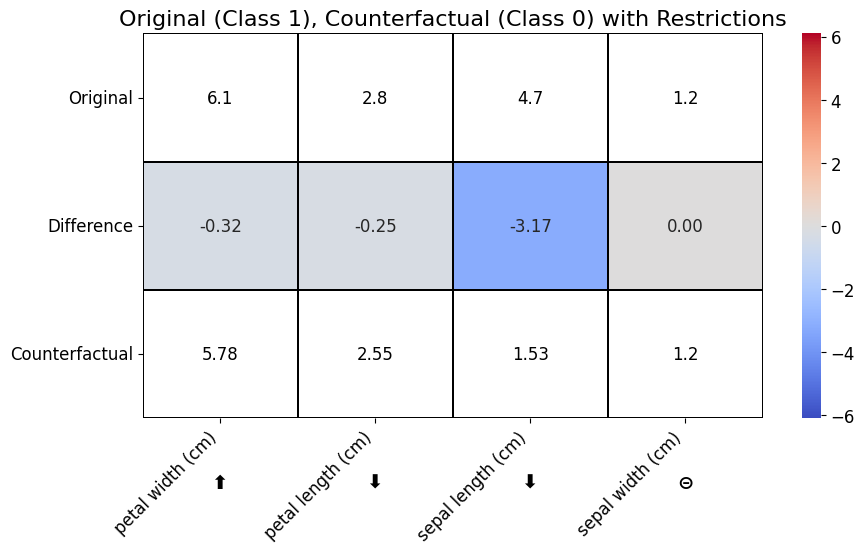

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set larger font sizes globally
plt.rcParams['font.size'] = 12  # Adjusts the default font size
plt.rcParams['axes.labelsize'] = 16  # Font size for x and y labels
plt.rcParams['axes.titlesize'] = 16  # Font size for the plot title
plt.rcParams['xtick.labelsize'] = 12  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for y-axis tick labels

def plot_sample_and_counterfactual_heatmap(sample, class_sample, counterfactual, class_counterfactual, restrictions):
    """
    Plot the original sample, the differences, and the counterfactual as a heatmap,
    and indicate restrictions using icons.

    Args:
        sample (dict): Original sample values.
        counterfactual (dict): Counterfactual sample values.
        restrictions (dict): Restrictions applied to each feature.
    """
    # Create DataFrame from the samples
    sample_df = pd.DataFrame([sample], index=['Original'])
    cf_df = pd.DataFrame([counterfactual], index=['Counterfactual'])

    # Calculate differences
    differences = (cf_df.loc['Counterfactual'] - sample_df.loc['Original']).to_frame('Difference').T

    # Combine all data
    full_df = pd.concat([sample_df, differences, cf_df])

    # Map restrictions to symbols
    symbol_map = {
        'no_change': '⊝',  # Locked symbol for no change
        'non_increasing': '⬇️',  # Down arrow for non-increasing
        'non_decreasing': '⬆️'  # Up arrow for non-decreasing
    }
    restrictions_ser = pd.Series(restrictions).replace(symbol_map)

    mask = np.full_like(full_df, False, dtype=bool)  # Start with no masking
    mask[[0, -1], :] = True  # Only mask the first and last rows


    vmax = np.max(np.abs(full_df.values))
    vmin = -vmax

    # Plotting the heatmap for numeric data
    plt.figure(figsize=(10, 5))
    ax = sns.heatmap(full_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=1.2, linecolor='k',
                     vmin=vmin, vmax=vmax, mask=mask)

    # Annotate with restrictions
    for i, (feat, restr) in enumerate(restrictions_ser.items()):
        ax.text(i + 0.5, 3.5, restr, ha='center', va='center', color='black', fontweight='bold', fontsize=14)

    annotations = full_df.round(2).copy().astype(str)
    for col in full_df.columns:
        annotations.loc['Difference', col] = f"Δ {full_df.loc['Difference', col]:.2f}"

    for (i, j), val in np.ndenumerate(full_df):
        if i == 1:
            continue
        ax.text(j + 0.5, i + 0.5, annotations.iloc[i, j],
                horizontalalignment='center', verticalalignment='center', color='black')


    plt.title(f'Original (Class {class_sample}), Counterfactual (Class {class_counterfactual}) with Restrictions')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0, va="center")
    plt.show()

# Example usage
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
counterfactual = {'petal width (cm)': 5.78, 'petal length (cm)': 2.55, 'sepal length (cm)': 1.53, 'sepal width (cm)': 1.2}
class_sample = model.predict(pd.DataFrame([sample]))[0]
class_counterfactual = model.predict(pd.DataFrame([counterfactual]))[0]
restrictions = {'petal width (cm)': 'non_decreasing', 'petal length (cm)': 'non_increasing', 'sepal length (cm)': 'non_increasing', 'sepal width (cm)': 'no_change'}
plot_sample_and_counterfactual_heatmap(sample, class_sample,  counterfactual, class_counterfactual, restrictions)


Original: {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
Generated Counterfactual: {'petal width (cm)': np.float64(6.1), 'petal length (cm)': np.float64(2.46), 'sepal length (cm)': np.float64(5.4), 'sepal width (cm)': np.float64(0.76)}
Predicted Class for Original Sample: [1]
Prediction Class CounterFactual [0]


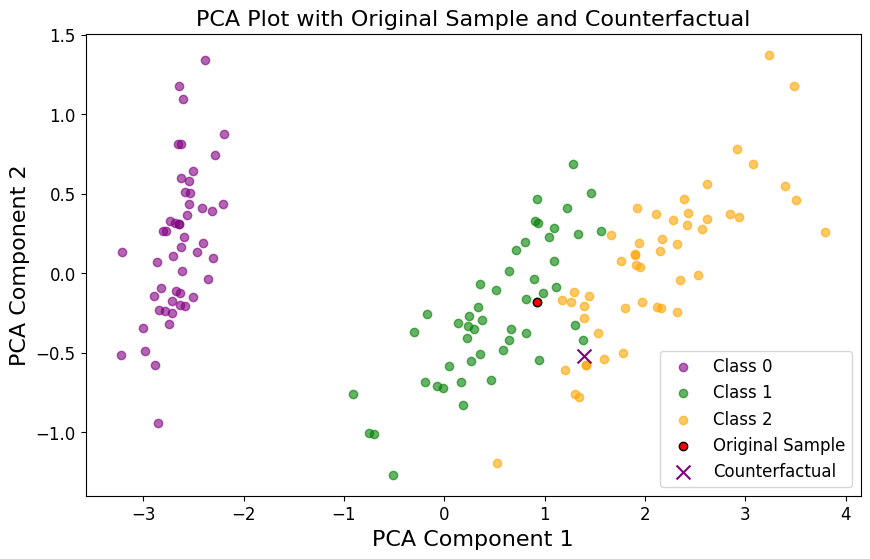

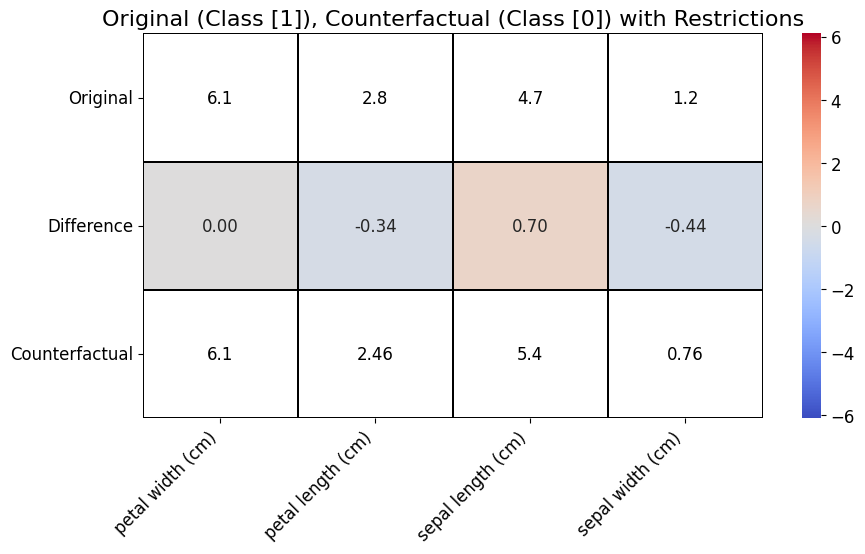

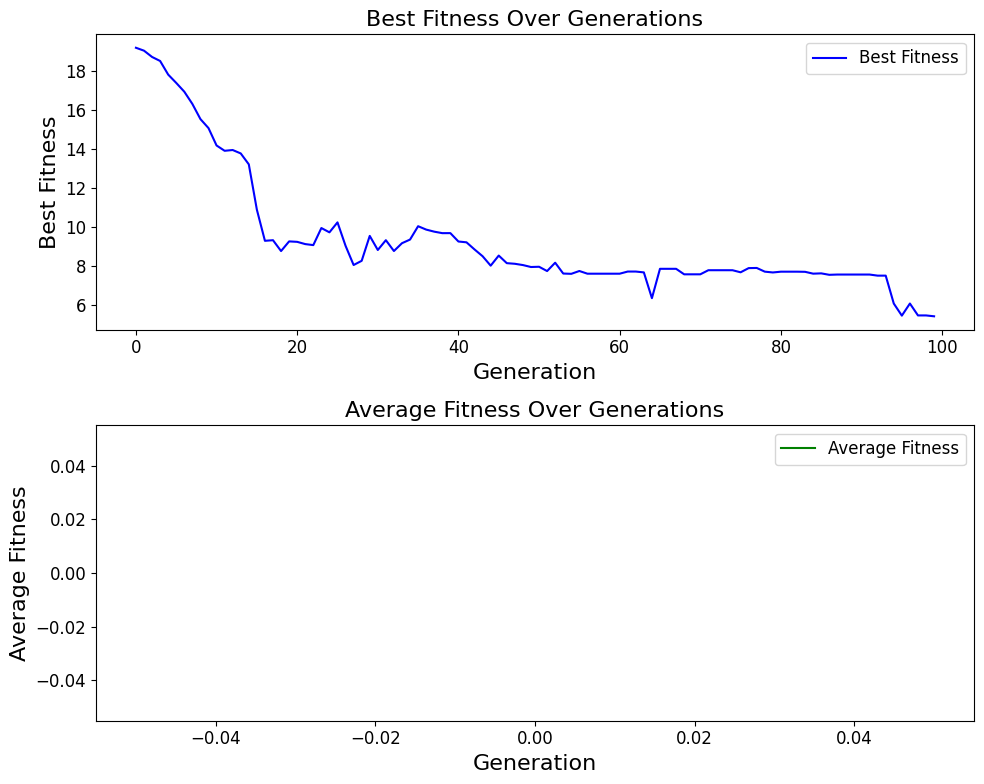

In [40]:
class CounterFactualDPG:
    def __init__(self, model, constraints, dict_non_actionable=None):
        """
        Initialize the CounterFactualDPG object.

        Args:
            model: The machine learning model used for predictions.
            constraints (dict): Nested dictionary containing constraints for features.
            dict_non_actionable (dict): Dictionary mapping features to non-actionable constraints.
              non_decreasing: feature cannot decrease
              non_increasing: feature cannot increase
              no_change: feature cannot change
        """
        self.model = model
        self.constraints = constraints
        self.dict_non_actionable = dict_non_actionable #non_decreasing, non_increasing, no_change
        self.average_fitness_list = []
        self.best_fitness_list = []

    def is_actionable_change(self, counterfactual_sample, original_sample):
      """
      Check if changes in features are actionable based on constraints.

      Args:
          counterfactual_sample (dict): The modified sample with new feature values.
          original_sample (dict): The original sample with feature values.

      Returns:
          bool: True if all changes are actionable, False otherwise.
      """
      if not self.dict_non_actionable:
          return True

      for feature, new_value in counterfactual_sample.items():
          if feature not in self.dict_non_actionable:
              continue

          original_value = original_sample.get(feature)
          constraint = self.dict_non_actionable[feature]

          if constraint == "non_decreasing" and new_value < original_value:
              return False
          if constraint == "non_increasing" and new_value > original_value:
              return False
          if constraint == "no_change" and new_value != original_value:
              return False

      return True


    def check_validity(self, counterfactual_sample, original_sample, desired_class):
        """
        Checks the validity of a counterfactual sample.

        Parameters:
        - counterfactual_sample: Array-like, shape (n_features,), the counterfactual sample.
        - original_sample: Array-like, shape (n_features,), the original input sample.
        - desired_class: The desired class label.

        Returns:
        - 0 if the predicted class matches the desired class and the sample is different from the original.
        - np.inf if the predicted class does not match the desired class or the sample is identical to the original.
        """
        # Ensure the input samples are numpy arrays
        counterfactual_sample = np.array(counterfactual_sample).reshape(1, -1)
        original_sample = np.array(original_sample).reshape(1, -1)

        # Check if the counterfactual sample is different from the original sample
        if np.array_equal(counterfactual_sample, original_sample):
            return False  # Return np.inf if the samples are identical

        # Predict the class for the counterfactual sample
        #print('self.model.predict(counterfactual_sample)[0]', self.model.predict(counterfactual_sample)[0])
        predicted_class = self.model.predict(counterfactual_sample)[0]

        # Check if the predicted class matches the desired class
        if predicted_class == desired_class:
            return True
        else:
            return False

    def plot_fitness(self):
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Create two subplots vertically

        # Plot best fitness
        axs[0].plot(self.best_fitness_list, label='Best Fitness', color='blue')
        axs[0].set_title('Best Fitness Over Generations')
        axs[0].set_xlabel('Generation')
        axs[0].set_ylabel('Best Fitness')
        axs[0].legend()

        # Plot average fitness
        axs[1].plot(self.average_fitness_list, label='Average Fitness', color='green')
        axs[1].set_title('Average Fitness Over Generations')
        axs[1].set_xlabel('Generation')
        axs[1].set_ylabel('Average Fitness')
        axs[1].legend()

        plt.tight_layout()
        plt.show()



    def calculate_distance(self,original_sample, counterfactual_sample, metric="euclidean"):
        """
        Calculates the distance between the original sample and the counterfactual sample.

        Parameters:
        - original_sample: Array-like, shape (n_features,), the original input sample.
        - counterfactual_sample: Array-like, shape (n_features,), the counterfactual sample.
        - metric: String, the distance metric to use. Options are "euclidean", "manhattan", or "cosine".

        Returns:
        - Distance between the original sample and the counterfactual sample.
        """
        # Ensure inputs are numpy arrays
        original_sample = np.array(original_sample)
        counterfactual_sample = np.array(counterfactual_sample)

        # Validate metric and compute distance
        if metric == "euclidean":
            distance = euclidean(original_sample, counterfactual_sample)
        elif metric == "manhattan":
            distance = cityblock(original_sample, counterfactual_sample)
        elif metric == "cosine":
            # Avoid division by zero in cosine similarity
            if np.all(original_sample == 0) or np.all(counterfactual_sample == 0):
                distance = 1  # Max cosine distance if one vector is zero
            else:
                distance = cosine(original_sample, counterfactual_sample)
        else:
            raise ValueError("Invalid metric. Choose from 'euclidean', 'manhattan', or 'cosine'.")

        return distance

    def validate_constraints(self, S_prime, sample, target_class):
        """
        Validate if the modified sample S_prime meets all constraints for the specified target class.

        Args:
            S_prime (dict): Modified sample with feature values.
            sample (dict): The original sample with feature values.
            target_class (int): The target class for filtering constraints.

        Returns:
            (bool, float): Tuple of whether the changes are valid and a penalty score.
        """
        penalty = 0.0
        valid_change = True

        # Filter the constraints for the specified target class
        class_constraints = self.constraints.get(str("Class "+str(target_class)), [])

        for feature, new_value in S_prime.items():
            original_value = sample.get(feature)

            # Check if the feature value has changed
            if new_value != original_value:
                # Validate numerical constraints specific to the target class
                for condition in class_constraints:
                    if condition["feature"] == feature:
                        operator = condition["operator"]
                        constraint_value = condition["value"]

                        #print("Feature:", feature)
                        #print("Operator:", operator)
                        #print("Constraint Value:", constraint_value)
                        #print("New Value:", new_value)

                        # Check if the new value violates any constraints
                        if operator == "<" and not (new_value < constraint_value):
                            valid_change = False
                            penalty += constraint_value
                        elif operator == "<=" and not (new_value <= constraint_value):
                            valid_change = False
                            penalty += constraint_value
                        elif operator == ">" and not (new_value > constraint_value):
                            valid_change = False
                            penalty += constraint_value
                        elif operator == ">=" and not (new_value >= constraint_value):
                            valid_change = False
                            penalty += constraint_value

        # Collect all constraints that are NOT related to the target class
        non_target_class_constraints = [
            condition
            for class_name, conditions in self.constraints.items()
            if class_name != "Class " + str(target_class)  # Exclude the target class constraints
            for condition in conditions
        ]

        for feature, new_value in S_prime.items():
            original_value = sample.get(feature)

            # Check if the feature value has changed
            if new_value != original_value:
                # Validate numerical constraints NOT related to the target class
                for condition in non_target_class_constraints:
                    if condition["feature"] == feature:
                        operator = condition["operator"]
                        constraint_value = condition["value"]

                        # Check if the new value violates any constraints
                        if operator == "<" and (new_value < constraint_value):
                            valid_change = False
                            penalty += constraint_value
                        elif operator == "<=" and (new_value <= constraint_value):
                            valid_change = False
                            penalty += constraint_value
                        elif operator == ">" and (new_value > constraint_value):
                            valid_change = False
                            penalty += constraint_value
                        elif operator == ">=" and (new_value >= constraint_value):
                            valid_change = False
                            penalty += constraint_value


        #print('Total Penalty:', penalty)
        return valid_change, penalty


    def get_valid_sample(self, sample, target_class):
        """
        Generate a valid sample that meets all constraints for the specified target class
        while respecting actionable changes.

        Args:
            sample (dict): The sample with feature values.
            target_class (int): The target class for filtering constraints.

        Returns:
            dict: A valid sample that meets all constraints for the target class
                  and respects actionable changes.
        """
        adjusted_sample = sample.copy()  # Start with the original values

        for feature, original_value in sample.items():
            min_value = -np.inf
            max_value = np.inf

            # Filter the constraints for the specified target class
            class_constraints = self.constraints.get(f"Class {target_class}", [])

            # Find the constraints for this feature
            for condition in class_constraints:
                if condition["feature"] == feature:
                    operator = condition["operator"]
                    constraint_value = condition["value"]

                    # Update the min and max values based on the constraints
                    if operator == "<":
                        max_value = min(max_value, constraint_value - 1e-5)
                    elif operator == "<=":
                        max_value = min(max_value, constraint_value)
                    elif operator == ">":
                        min_value = max(min_value, constraint_value + 1e-5)
                    elif operator == ">=":
                        min_value = max(min_value, constraint_value)

            # Incorporate non-actionable constraints
            if self.dict_non_actionable and feature in self.dict_non_actionable:
                actionability = self.dict_non_actionable[feature]
                if actionability == "non_decreasing":
                    min_value = max(min_value, original_value)
                elif actionability == "non_increasing":
                    max_value = min(max_value, original_value)
                elif actionability == "no_change":
                    adjusted_sample[feature] = original_value
                    continue

            # Generate a random value within the valid range
            if min_value == -np.inf:
                min_value = 0  # Default lower bound if no constraint is specified
            if max_value == np.inf:
                max_value = min_value + 10  # Default upper bound if no constraint is specified

            adjusted_sample[feature] = np.random.uniform(min_value, max_value)

        return adjusted_sample

    def calculate_sparsity(self, original_sample, counterfactual_sample):
        total_features = len(original_sample)
        unchanged_features = sum(
            original_sample[feature]*3 for feature in original_sample if original_sample[feature] != counterfactual_sample[feature]
        )
        sparsity = unchanged_features / total_features
        return sparsity

    def calculate_fitness(self, individual, original_features, sample, target_class, metric="cosine"):
            """
            Calculate the fitness score for an individual sample.

            Args:
                individual (dict): The individual sample with feature values.
                original_features (np.array): The original feature values.
                sample (dict): The original sample with feature values.
                target_class (int): The desired class for the counterfactual.
                metric (str): The distance metric to use for calculating distance.

            Returns:
                float: The fitness score for the individual.
            """
            #print('individual', individual)

            # Convert individual feature values to a numpy array
            features = np.array([individual[feature] for feature in sample.keys()]).reshape(1, -1)

            # Calculate validity score based on class
            is_valid_class = self.check_validity(features.flatten(), original_features.flatten(), target_class)
            #print('is_valid_class', is_valid_class)

            # Calculate distance score
            distance_score = self.calculate_distance(original_features, features.flatten(), metric)

            #Calculate sparcity (number of features modified)
            sparsity_score = self.calculate_sparsity(sample, individual)

            # Calculate_manufold_distance
            #manifold_distance = self.calculate_manifold_distance(self.X, individual)
            #print('calculate_manifold_distance', manifold_distance)

            # Check the constraints
            is_valid_constraint, penalty_constraints = self.validate_constraints(individual, sample, target_class)

            # Check if the change is actionable
            if not self.is_actionable_change(individual, sample) or not is_valid_class:
                fitness = +np.inf
                return fitness

            if is_valid_class :
                fitness = (2*distance_score) + penalty_constraints + sparsity_score
            elif is_valid_constraint:
                fitness = 5 * ((2*distance_score) + penalty_constraints + sparsity_score)  # High penalty for invalid samples
            else:
                fitness = 10 * ((2*distance_score) + penalty_constraints + sparsity_score)  # High penalty for invalid samples

            return fitness


    def genetic_algorithm(self, sample, target_class, population_size=100, generations=100, mutation_rate=0.8, metric="euclidean", delta_threshold=0.01, patience=20):
      # Initialize population with random values within a reasonable range
      population = []
      feature_names = list(sample.keys())
      previous_best_fitness = float('inf')
      stable_generations = 0  # Counter for generations with minimal fitness improvement

      for _ in range(population_size):
          individual = self.get_valid_sample(sample, target_class)
          population.append(individual)

      original_features = np.array([sample[feature] for feature in feature_names])

      self.best_fitness_list = []
      self.average_fitness_list = []
      # Main loop for generations
      for generation in range(generations):
          fitness_scores = []

          # Calculate fitness for each individual
          for individual in population:
              fitness = self.calculate_fitness(individual, original_features, sample, target_class, metric)
              fitness_scores.append(fitness)

          # Find the best candidate and its fitness score
          best_index = np.argmin(fitness_scores)
          best_candidate = population[best_index]
          best_fitness = fitness_scores[best_index]

          # Check for convergence based on the fitness delta threshold
          fitness_improvement = previous_best_fitness - best_fitness
          if fitness_improvement < delta_threshold:
              stable_generations += 1
          else:
              stable_generations = 0  # Reset if there's sufficient improvement

          # Print the average fitness and the best candidate
          #print(f"****** Generation {generation + 1}: Average Fitness = {np.mean(fitness_scores):.4f}, Best Fitness = {best_fitness:.4f}, fitness improvement = {fitness_improvement:.4f}")

          previous_best_fitness = best_fitness
          self.best_fitness_list.append(best_fitness)
          self.average_fitness_list.append(np.mean(fitness_scores))

          # Stop if improvement is less than the threshold for a consecutive number of generations
          if stable_generations >= patience:
              print(f"Convergence reached at generation {generation + 1}")
              break

            # Use tournament selection to choose parents
          selected_parents = []
          for _ in range(population_size):
              tournament = np.random.choice(population, size=4, replace=False)
              tournament_fitness = [fitness_scores[population.index(ind)] for ind in tournament]
              selected_parents.append(tournament[np.argmin(tournament_fitness)])

          # Generate new population using crossover and mutation
          new_population = []
          for parent in selected_parents:
              offspring = parent.copy()
              for feature in feature_names:
                  if np.random.rand() < mutation_rate:
                      # Apply mutation only if the feature is actionable
                      if self.dict_non_actionable and feature in self.dict_non_actionable:
                          actionability = self.dict_non_actionable[feature]
                          original_value = parent[feature]
                          if actionability == "non_decreasing":
                              mutation_value = np.random.uniform(0, 0.5)  # Only allow increase
                              offspring[feature] += mutation_value
                          elif actionability == "non_increasing":
                              mutation_value = np.random.uniform(-0.5, 0)  # Only allow decrease
                              offspring[feature] += mutation_value
                          elif actionability == "no_change":
                              offspring[feature] = original_value  # Do not change
                          else:
                              # If no specific actionability rule, apply normal mutation
                              offspring[feature] += np.random.uniform(-0.5, 0.5)
                      else:
                          # If the feature is not in the non-actionable list, apply normal mutation
                          offspring[feature] += np.random.uniform(-0.5, 0.5)

                      # Ensure offspring values stay within valid domain constraints
                      offspring[feature] = np.round(max(0, offspring[feature]), 2)  # Adjust this based on domain-specific constraints
              new_population.append(offspring)


          # Reduce mutation rate over generations (adaptive mutation)
          mutation_rate *= 0.99

          # Update population
          population = new_population

      if best_fitness == np.inf:
          return None

      # Return the best individual based on the lowest fitness score
      best_index = np.argmin(fitness_scores)
      return population[best_index]




    def generate_counterfactual(self, sample, target_class):
        """
        Generate a counterfactual for the given sample and target class using a genetic algorithm.

        Args:
            sample (dict): The original sample with feature values.
            target_class (int): The desired class for the counterfactual.

        Returns:
            dict: A modified sample representing the counterfactual or None if not found.
        """
        sample_class = self.model.predict(pd.DataFrame([sample]))[0]
        # Check if the predicted class matches the desired class
        if sample_class == target_class:
            raise ValueError("Target class need to be different from the predicted class label.")
        #counterfactual = None
        #while counterfactual is None:
        counterfactual = self.genetic_algorithm(sample, target_class, population_size=100,  generations=100)
        return counterfactual

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# Original sample
#sample = {'petal width (cm)': 1.0, 'petal length (cm)': 2.0, 'sepal length (cm)': 1.0, 'sepal width (cm)': 3.5}
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}

# Create a DataFrame from the sample
sample_df = pd.DataFrame([sample])  # Wrapping sample in a list to create a DataFrame

# Initialize the CounterFactualDPG class with the model and constraints
cf_dpg = CounterFactualDPG(model, constraints)  # Ensure you are using the correct constraints (nested_dict)
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'no_change'}
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
#dict_non_actionable = {'petal width (cm)': 'no_change', 'sepal length (cm)': 'non_decreasing'}
dict_non_actionable = {}

cf_dpg.dict_non_actionable = dict_non_actionable

# Generate a counterfactual for the target class
counterfactual = cf_dpg.generate_counterfactual(sample, target_class=0)
print("Original:", sample)
print("Generated Counterfactual:", counterfactual)

# Predict the class for the original sample using the model
predicted_class = model.predict(sample_df)
print("Predicted Class for Original Sample:", predicted_class)
print('Prediction Class CounterFactual', model.predict(pd.DataFrame([counterfactual])))

plot_pca_with_counterfactual(model, X, y, sample, counterfactual)
plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)
cf_dpg.plot_fitness()

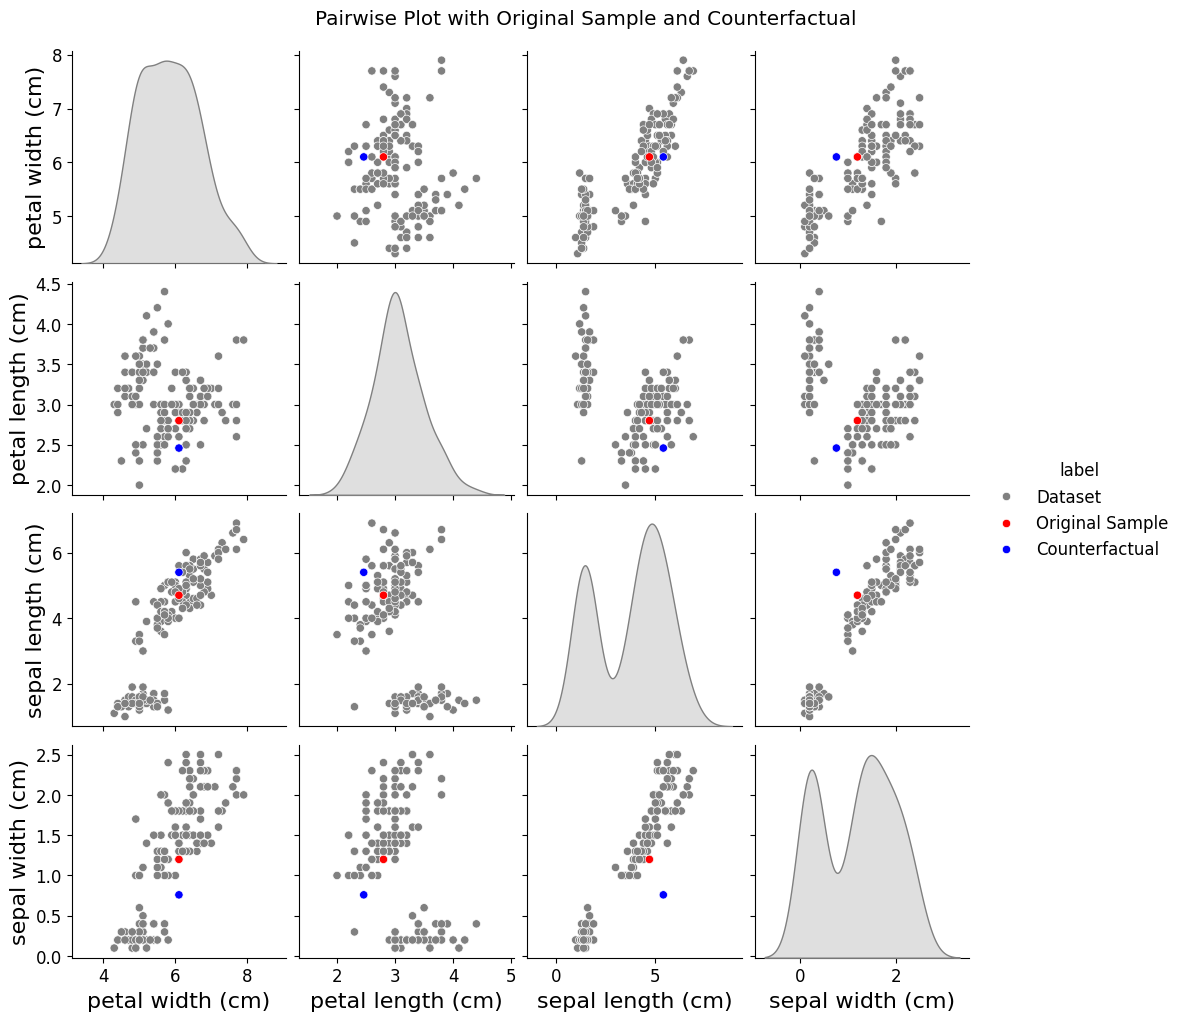

In [41]:
plot_pairwise_with_counterfactual(model, X, y, sample, counterfactual)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_pairwise_with_counterfactual_df(model, dataset, target, sample, counterfactual_df):
    """
    Plot pairwise plots of the dataset, highlighting the original sample and multiple counterfactuals using matplotlib.

    Args:
        model: Trained scikit-learn model used for predicting the class of the counterfactuals.
        dataset: The original dataset (features) used for the plot.
        target: The target labels for the dataset.
        sample: The original sample as a dictionary of feature values.
        counterfactual_df: DataFrame containing several counterfactual samples.
    """
    # Convert the dataset into a DataFrame
    data_df = pd.DataFrame(dataset, columns=list(sample.keys()))

    # Convert the original sample to DataFrame
    sample_df = pd.DataFrame([sample], index=['Original'])

    # Combine the dataset with marked samples
    combined_df = pd.concat([data_df, sample_df, counterfactual_df])

    # Get feature names
    features = list(sample.keys())
    num_features = len(features)

    # Create a grid of plots
    fig, axes = plt.subplots(nrows=num_features, ncols=num_features, figsize=(15, 15))

    # Plot each pair of features
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            ax = axes[i, j]
            if i != j:
                # Scatter plot for different features
                ax.scatter(data_df[feature_i], data_df[feature_j], c='gray', label='Dataset', alpha=0.5)
                ax.scatter(sample_df[feature_i], sample_df[feature_j], c='red', label='Original Sample', edgecolors='k', s=100)
                ax.scatter(counterfactual_df[feature_i], counterfactual_df[feature_j], c='blue', label='Counterfactuals', alpha=0.6, edgecolors='k', s=50)
            else:
                # Histogram on the diagonal
                ax.hist(data_df[feature_i], color='gray', bins=30, alpha=0.5)
                ax.hist(sample_df[feature_i], color='red', bins=1)
                ax.hist(counterfactual_df[feature_i], color='blue', bins=30, alpha=0.6)

            # Label axes if on the perimeter
            if i == num_features - 1:
                ax.set_xlabel(feature_j)
            if j == 0:
                ax.set_ylabel(feature_i)

    # Add legends and adjust layout
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have a trained model, a dataset (as a DataFrame or array), target labels, original sample, and counterfactual_df
# plot_pairwise_with_counterfactual_df(model, X, y, sample, counterfactuals_df)


Convergence reached at generation 21


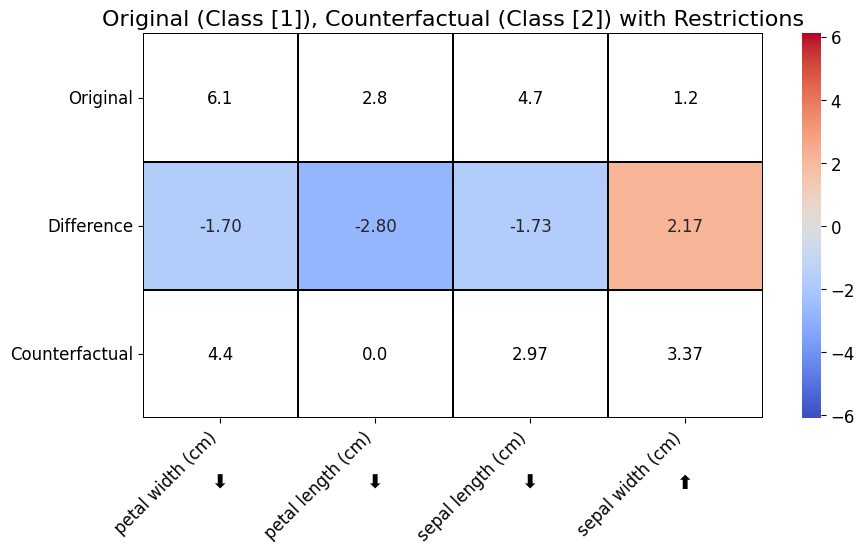

Convergence reached at generation 21


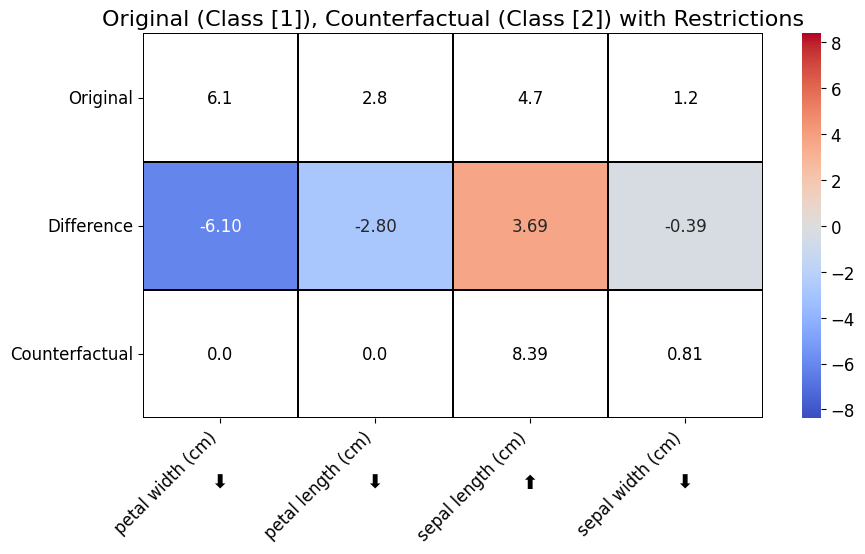

Convergence reached at generation 21


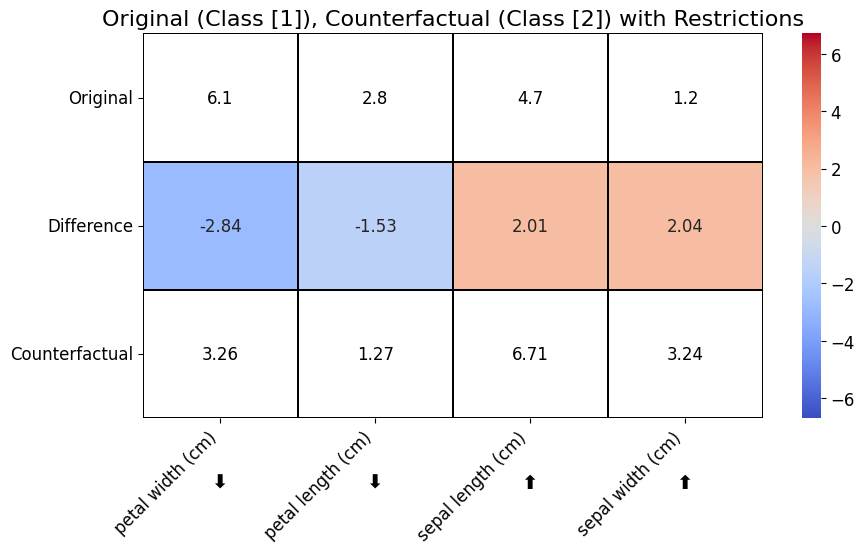

Convergence reached at generation 21


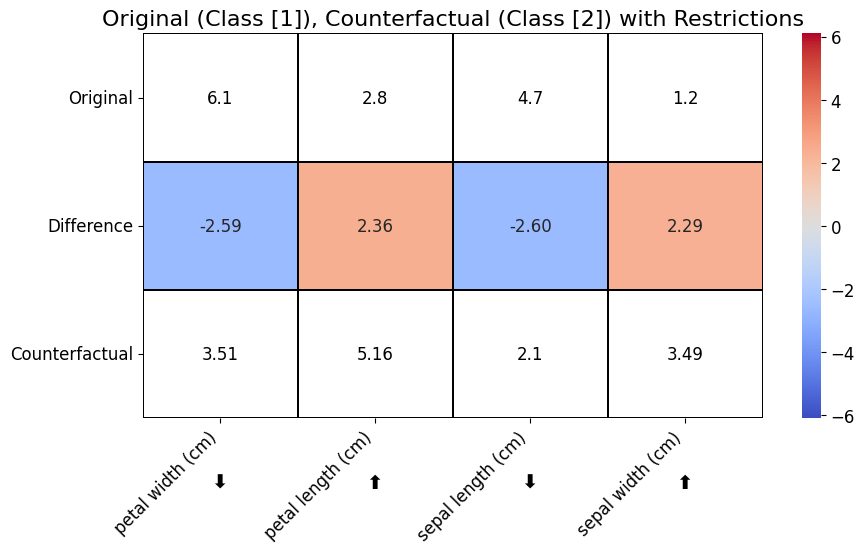

Convergence reached at generation 21


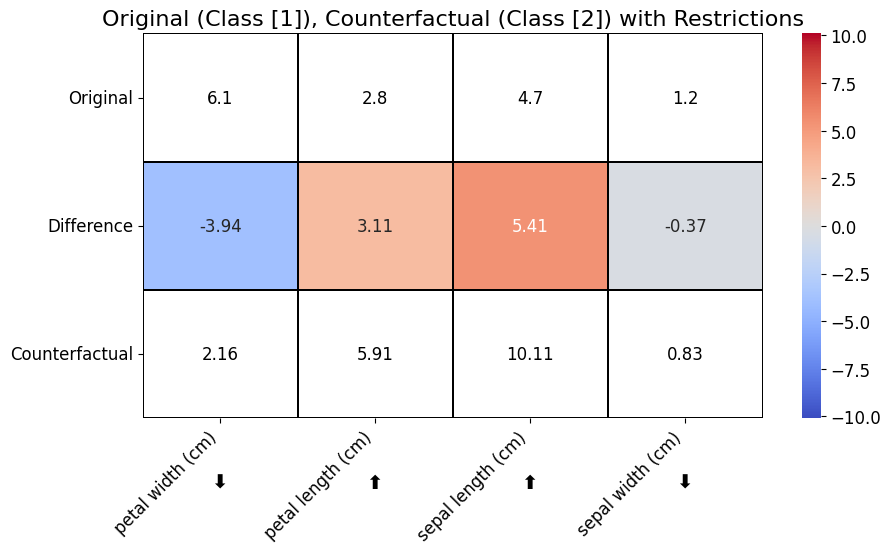

Convergence reached at generation 21


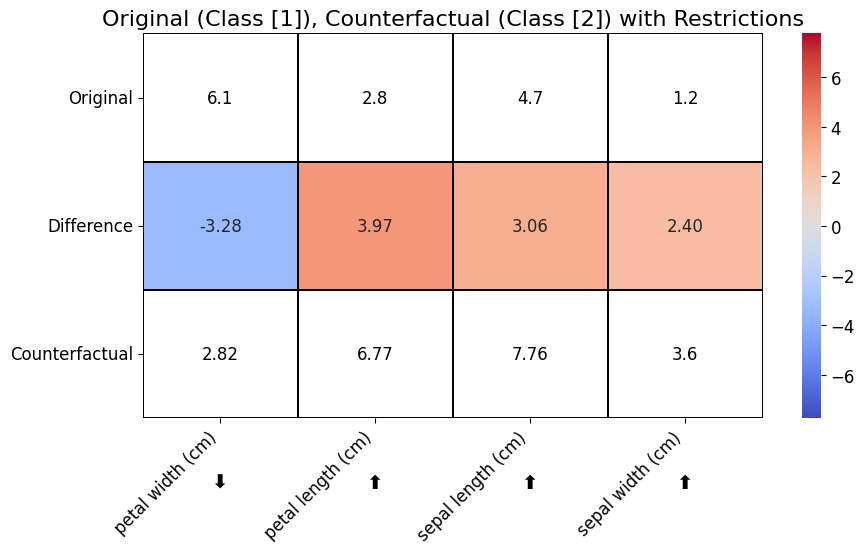

Convergence reached at generation 21


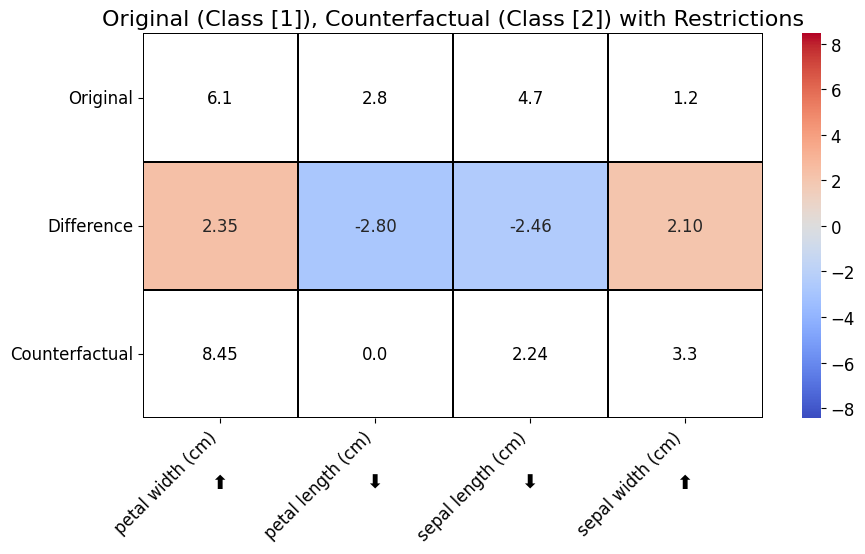

Convergence reached at generation 21


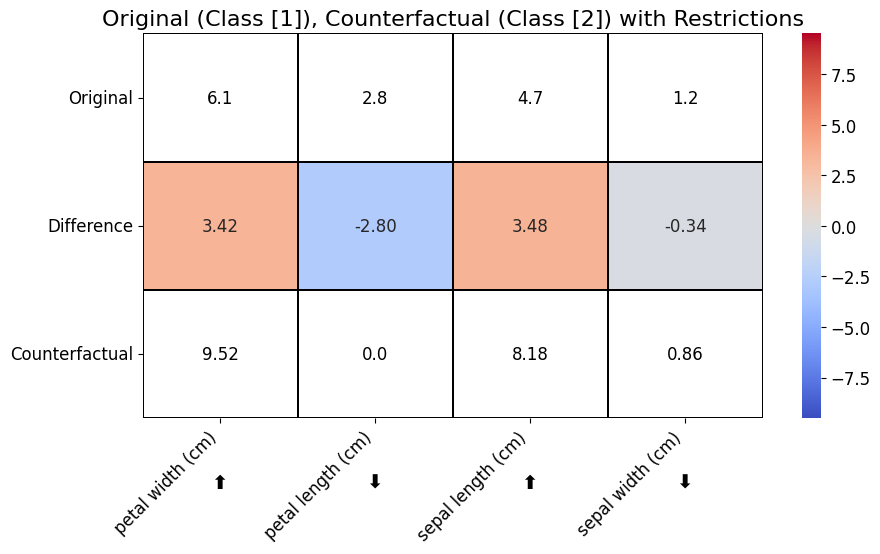

Convergence reached at generation 21


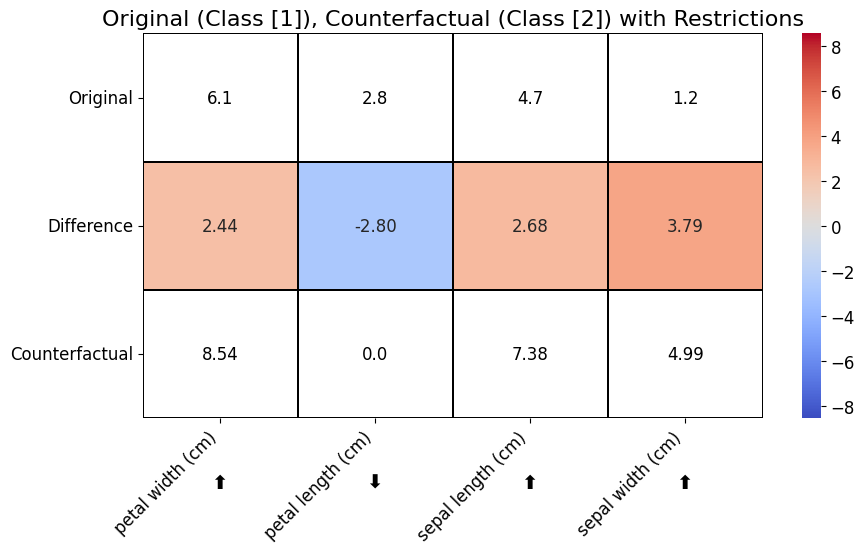

Convergence reached at generation 21


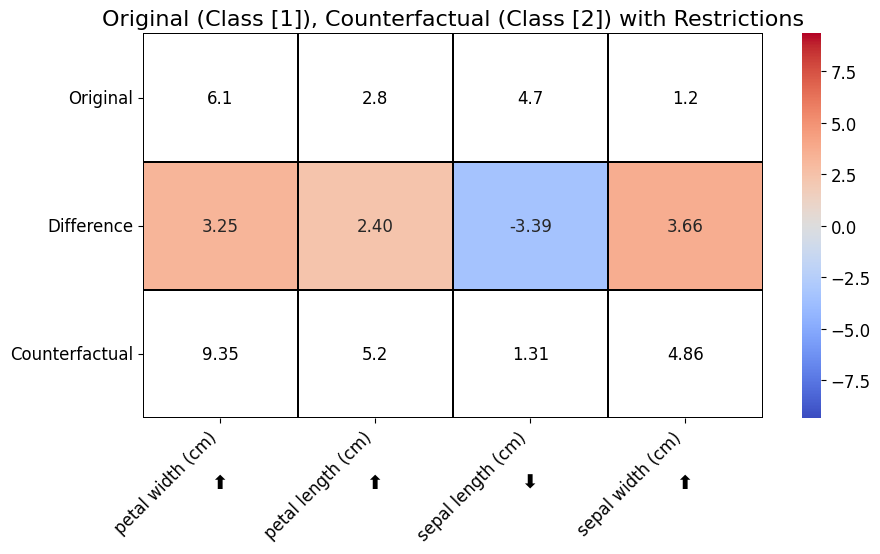

Convergence reached at generation 21


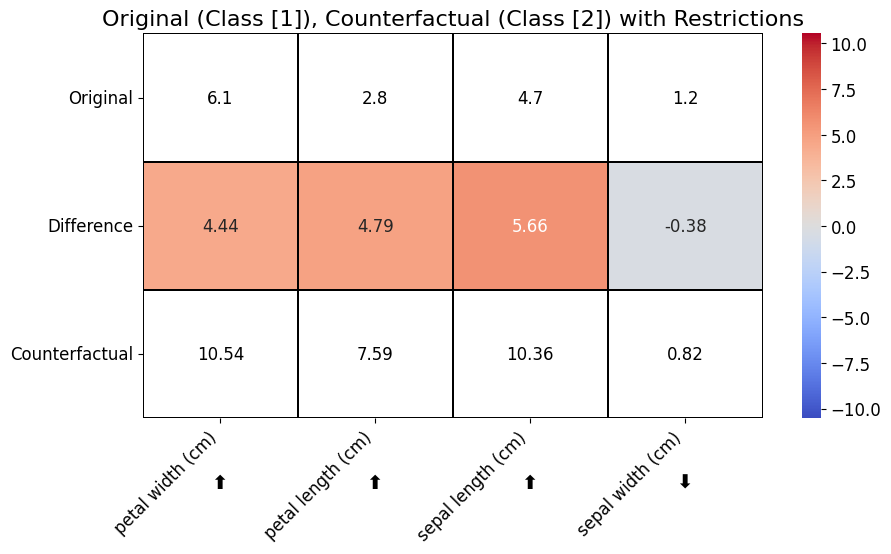

Convergence reached at generation 21


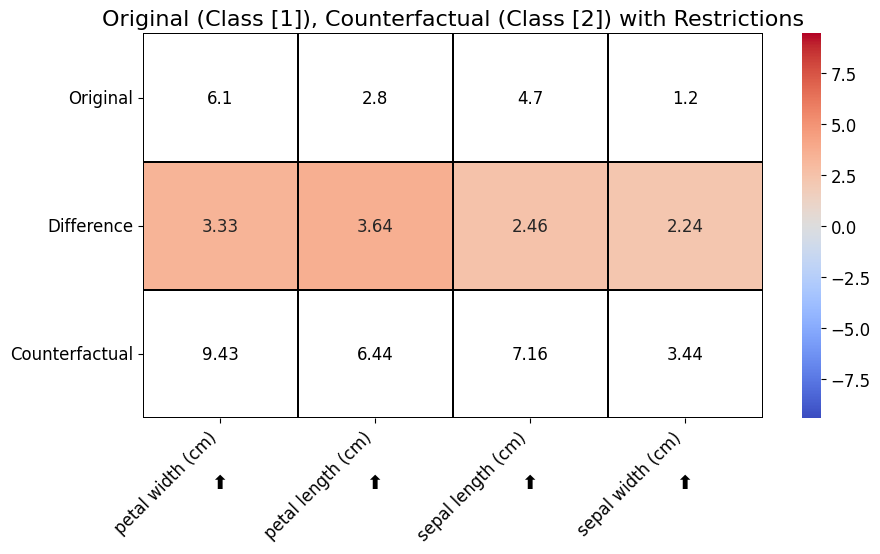

    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               4.40               0.00               2.97              3.37   
1               0.00               0.00               8.39              0.81   
2               3.26               1.27               6.71              3.24   
3               3.51               5.16               2.10              3.49   
4               2.16               5.91              10.11              0.83   
5               2.82               6.77               7.76              3.60   
6               8.45               0.00               2.24              3.30   
7               9.52               0.00               8.18              0.86   
8               8.54               0.00               7.38              4.99   
9               9.35               5.20               1.31              4.86   
10             10.54               7.59              10.36              0.82   
11              9.43               6.44 

In [44]:
import itertools

sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
#rules = ['no_change', 'non_increasing', 'non_decreasing']
rules = ['non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df = []

# Iterate through each combination of rules
for combination in rule_combinations:
    dict_non_actionable = dict(zip(feature_names, combination))

    # Create an instance of the CounterFactualDPG class
    cf_dpg = CounterFactualDPG(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df.append(cf_data)

counterfactuals_df = pd.DataFrame(counterfactuals_df)
# Displaying the DataFrame
print(counterfactuals_df)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_pca_with_counterfactuals(model, dataset, target, sample, counterfactuals_df):
    """
    Plot a PCA visualization of the dataset with the original sample and multiple counterfactuals from a DataFrame.
    """
    # Standardize the dataset
    scaler = StandardScaler()
    dataset_scaled = scaler.fit_transform(dataset.select_dtypes(include=[np.number]))

    # Perform PCA on the scaled dataset
    pca = PCA(n_components=2)
    iris_pca = pca.fit_transform(dataset_scaled)

    # Ensure the sample and counterfactuals are formatted as numeric DataFrame
    sample_df = pd.DataFrame([sample]).select_dtypes(include=[np.number])
    sample_df_scaled = scaler.transform(sample_df)
    if not isinstance(counterfactuals_df, pd.DataFrame):
        raise ValueError("counterfactuals_df must be a pandas DataFrame")

    numeric_cf_df = counterfactuals_df.select_dtypes(include=[np.number])
    numeric_cf_df_scaled = scaler.transform(numeric_cf_df)

    # Transform using PCA
    original_sample_pca = pca.transform(sample_df_scaled)
    counterfactuals_pca = pca.transform(numeric_cf_df_scaled)

    # Predict classes for counterfactuals
    counterfactual_classes = model.predict(numeric_cf_df)

    # Plot the PCA results
    plt.figure(figsize=(10, 6))
    colors = ['purple', 'green', 'orange']

    for class_value in np.unique(target):
        plt.scatter(
            iris_pca[target == class_value, 0],
            iris_pca[target == class_value, 1],
            label=f"Class {class_value}",
            color=colors[class_value % len(colors)],
            alpha=0.5
        )

    plt.scatter(
        original_sample_pca[:, 0], original_sample_pca[:, 1],
        color='red', label='Original Sample', edgecolor='black', s=100
    )

    for idx, cf_class in enumerate(counterfactual_classes):
        plt.scatter(
            counterfactuals_pca[idx, 0], counterfactuals_pca[idx, 1],
            color=colors[cf_class % len(colors)], marker='x', s=100, label=f'Counterfactual (Class {cf_class})', edgecolor='black'
        )

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Plot with Original Sample and Counterfactuals')
    #plt.legend()
    plt.show()

# Example usage:
# Assuming model, X, y, sample, counterfactuals_df are appropriately defined
# plot_pca_with_counterfactuals(model, pd.DataFrame(X), y, sample, counterfactuals_df)


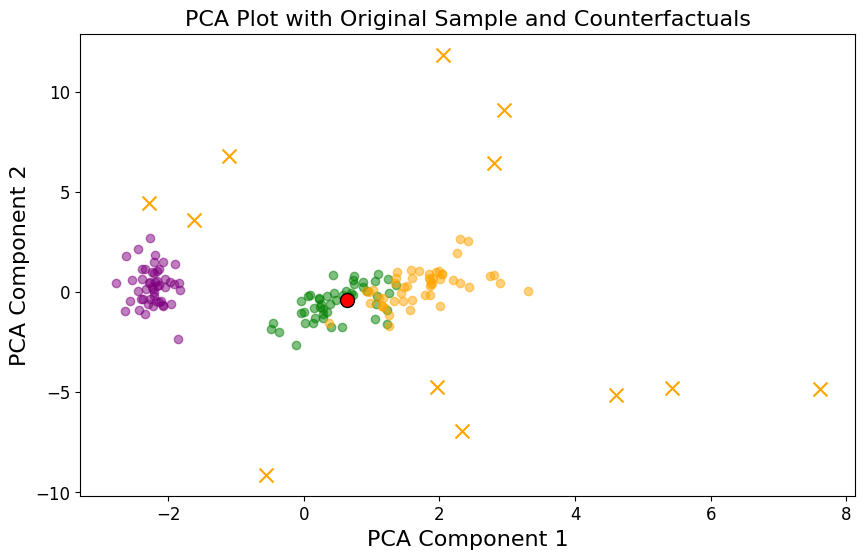

In [47]:
plot_pca_with_counterfactuals(model, pd.DataFrame(X), y, sample, counterfactuals_df)

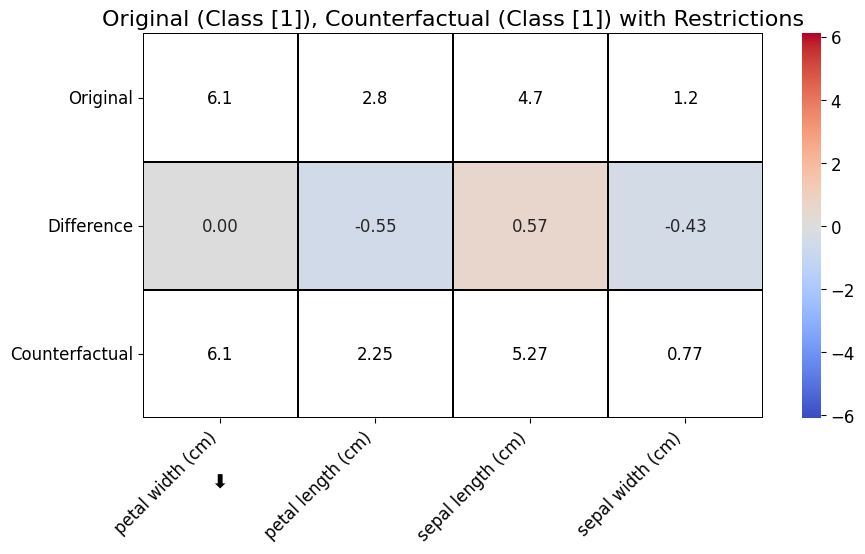

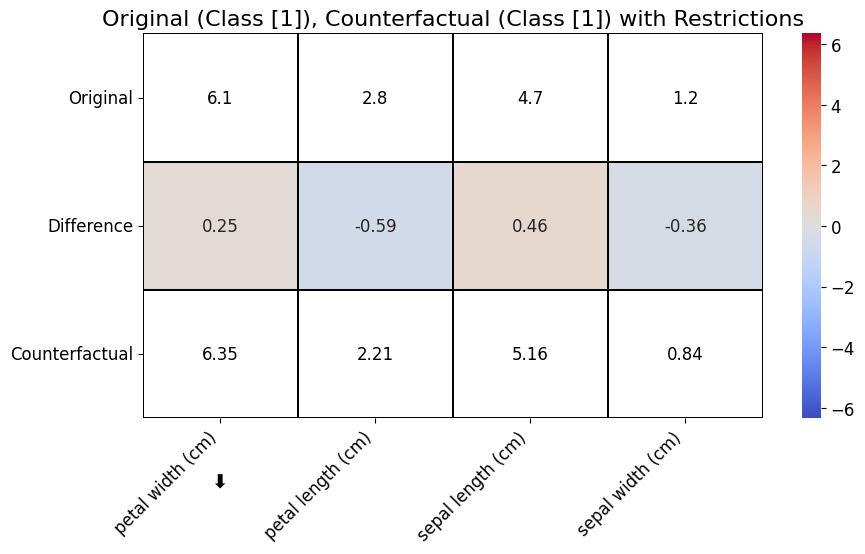

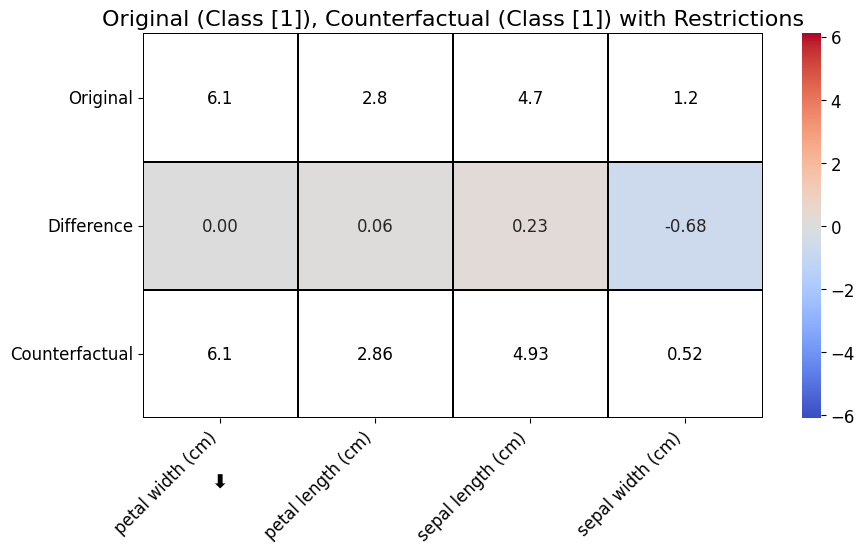

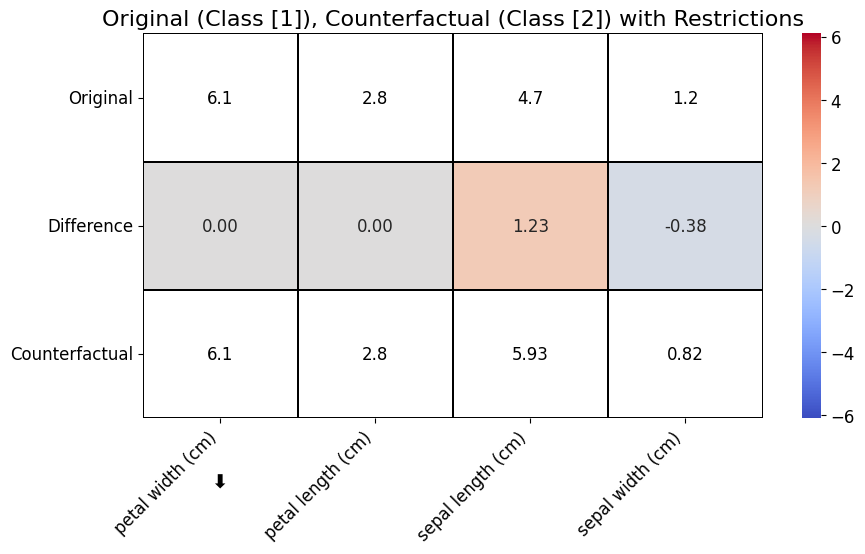

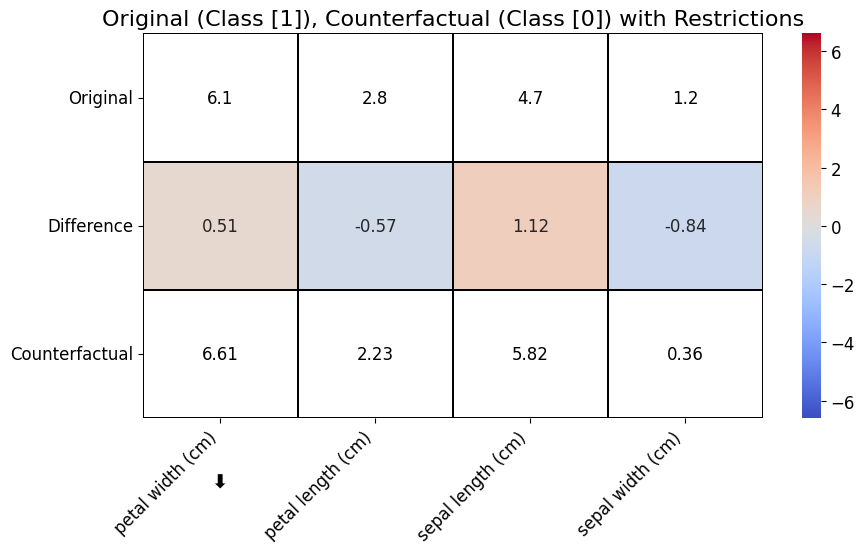

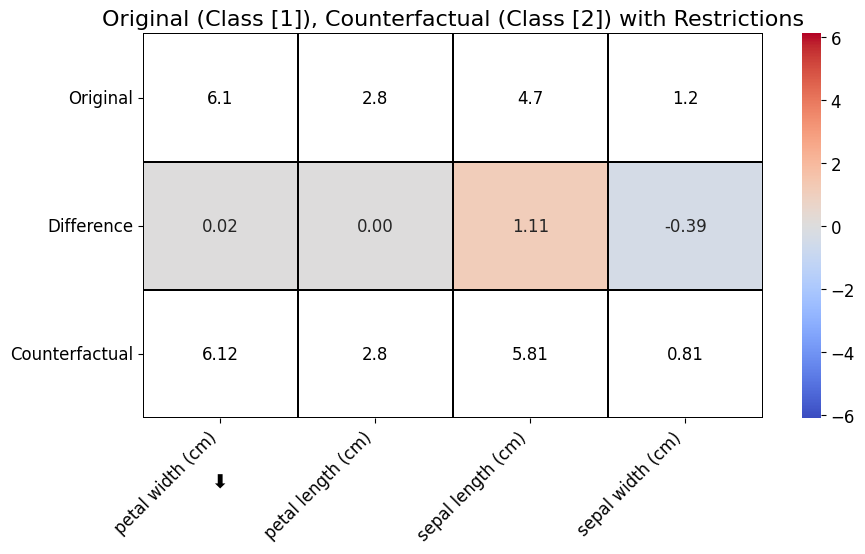

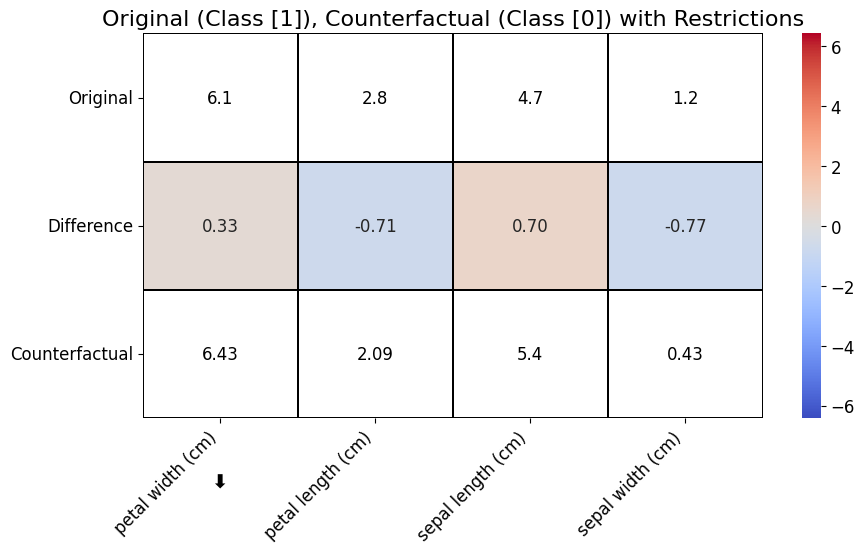

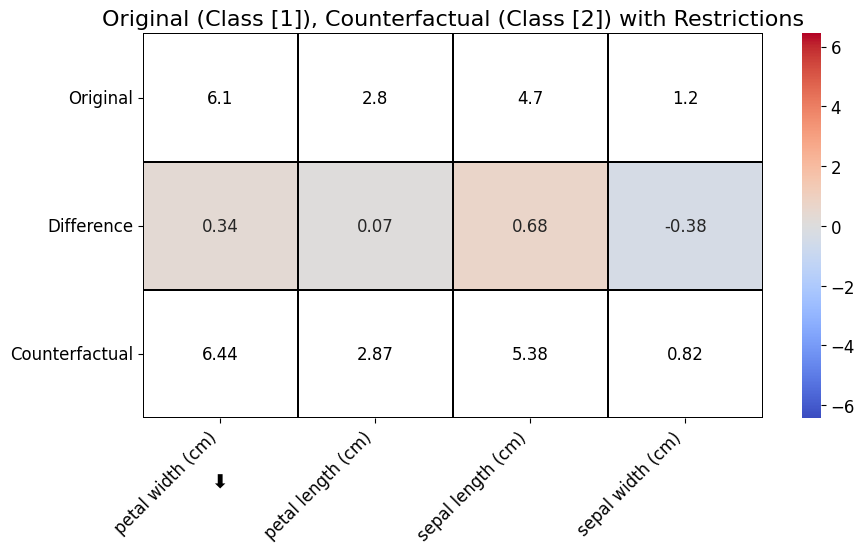

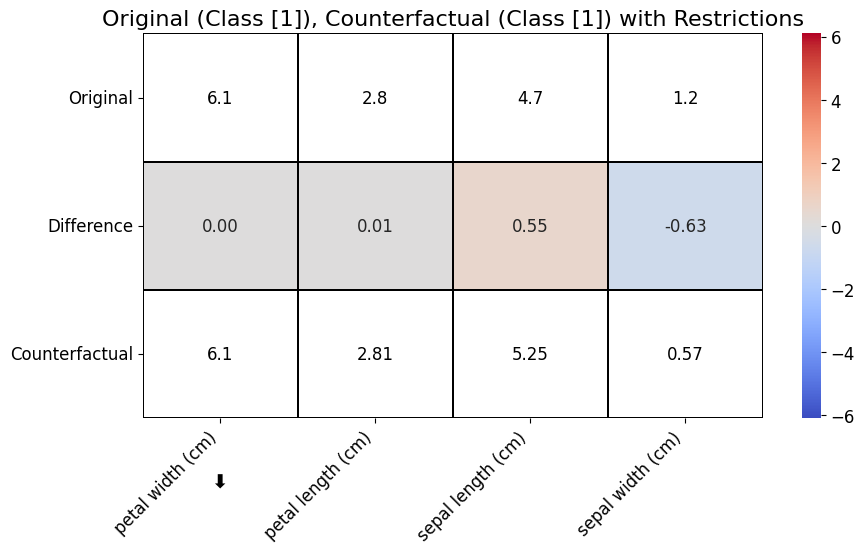

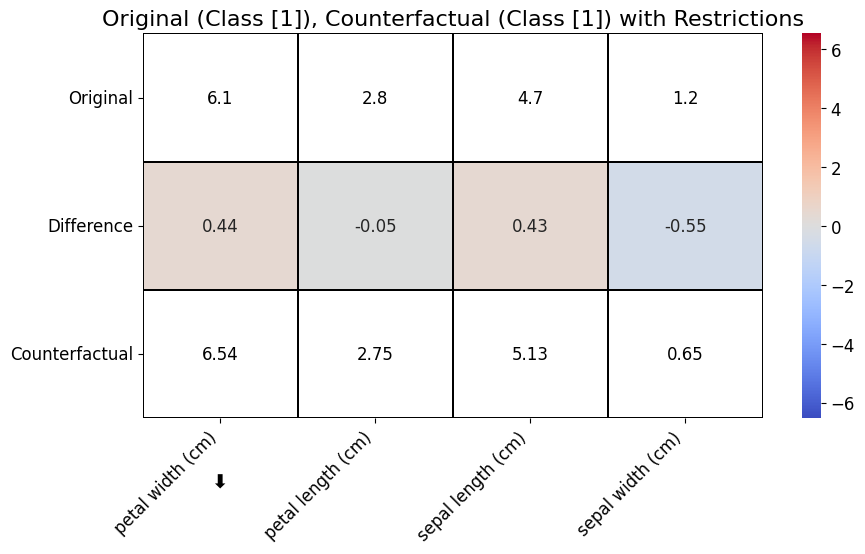

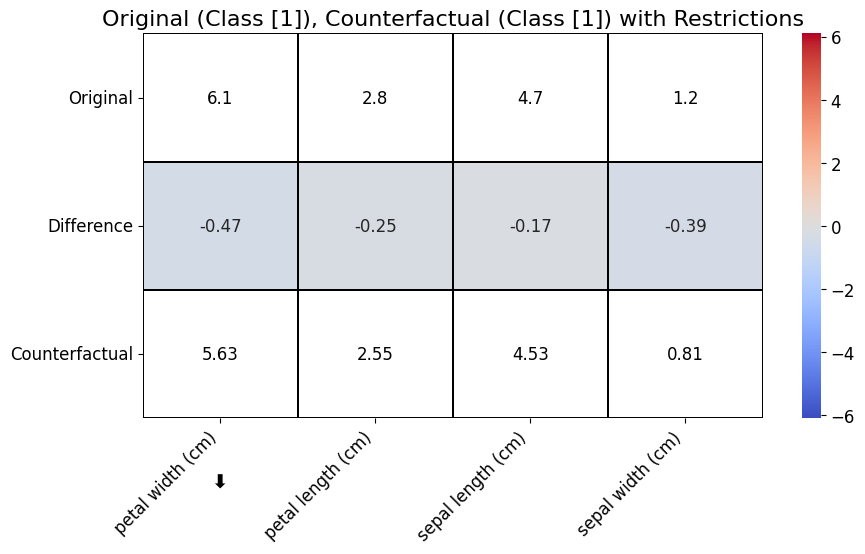

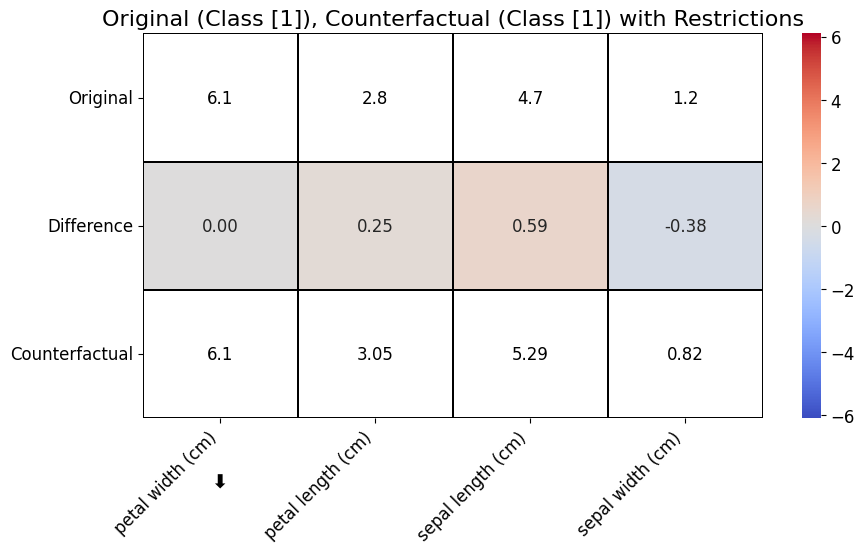

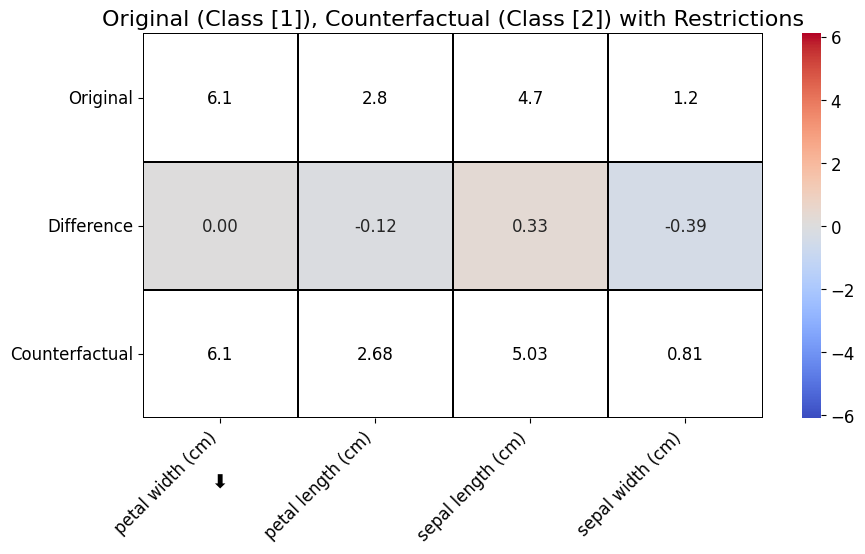

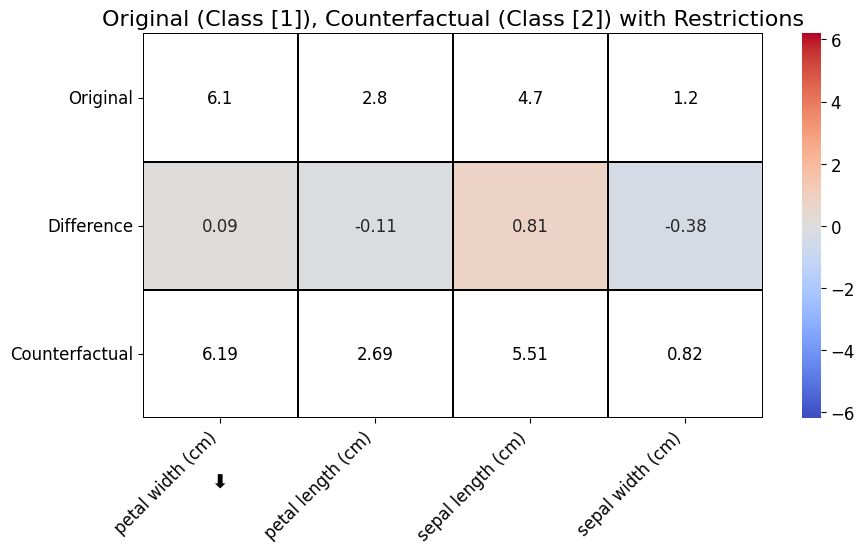

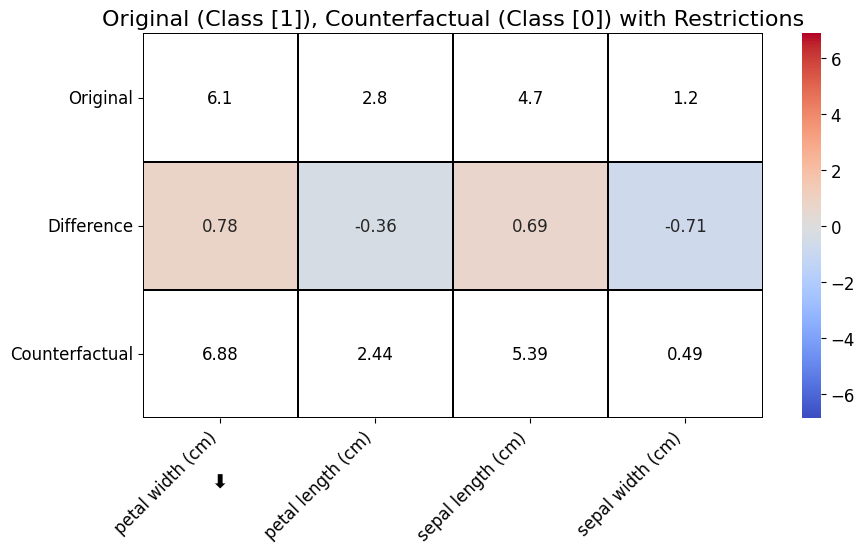

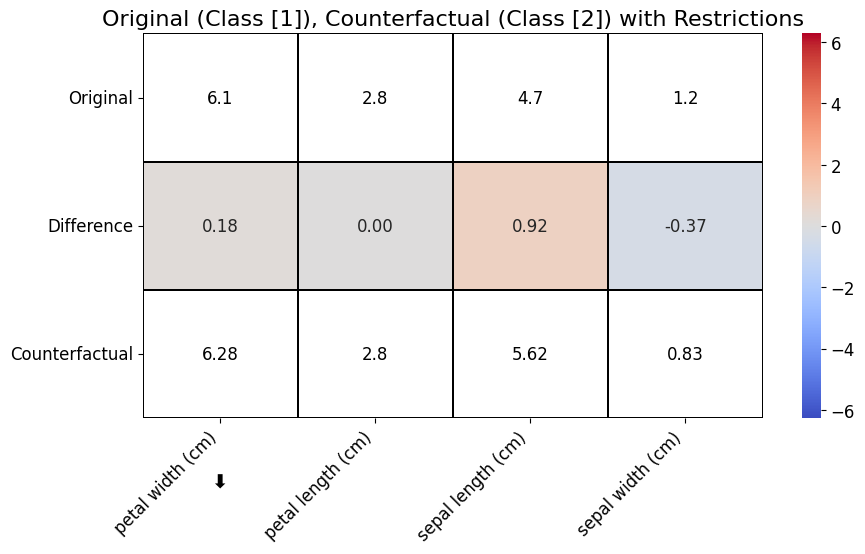

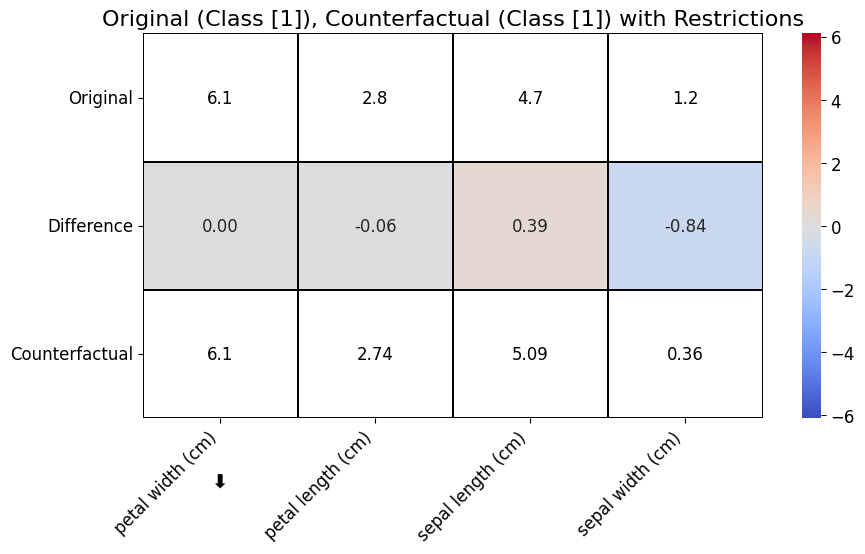

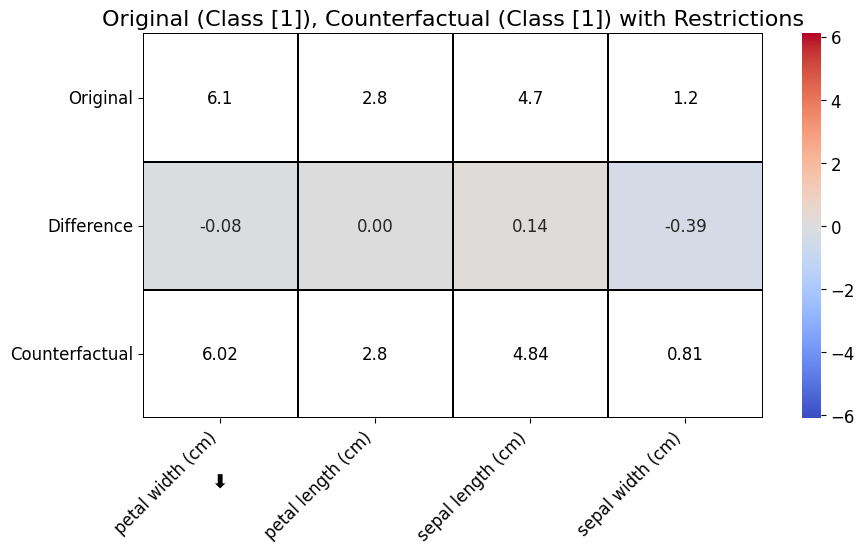

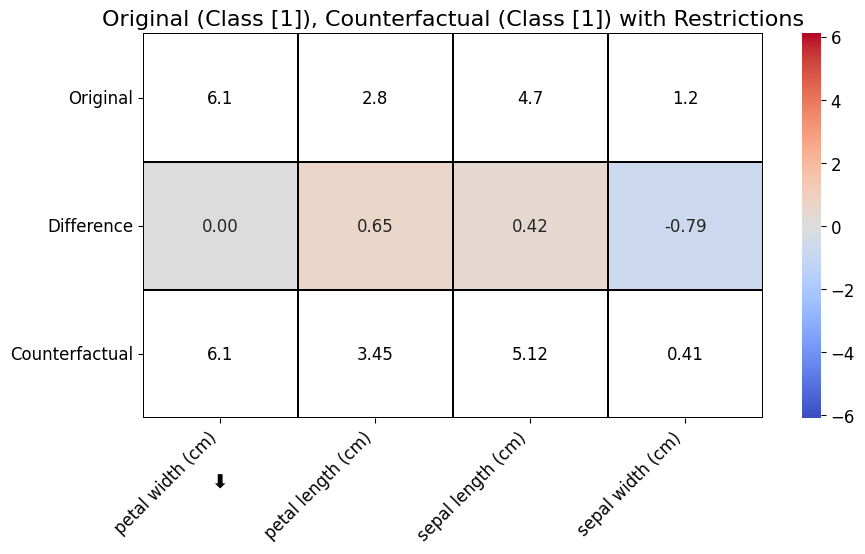

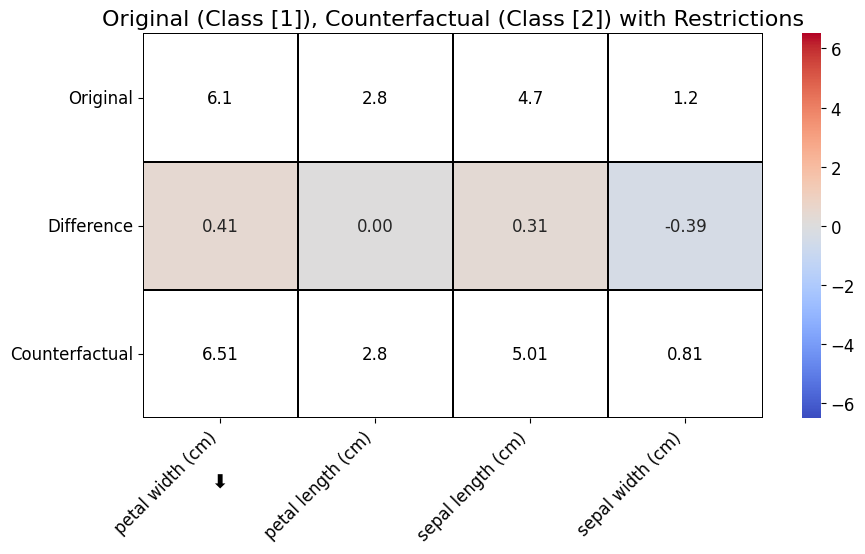

    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               6.10               2.25               5.27              0.77   
1               6.35               2.21               5.16              0.84   
2               6.10               2.86               4.93              0.52   
3               6.10               2.80               5.93              0.82   
4               6.61               2.23               5.82              0.36   
5               6.12               2.80               5.81              0.81   
6               6.43               2.09               5.40              0.43   
7               6.44               2.87               5.38              0.82   
8               6.10               2.81               5.25              0.57   
9               6.54               2.75               5.13              0.65   
10              5.63               2.55               4.53              0.81   
11              6.10               3.05 

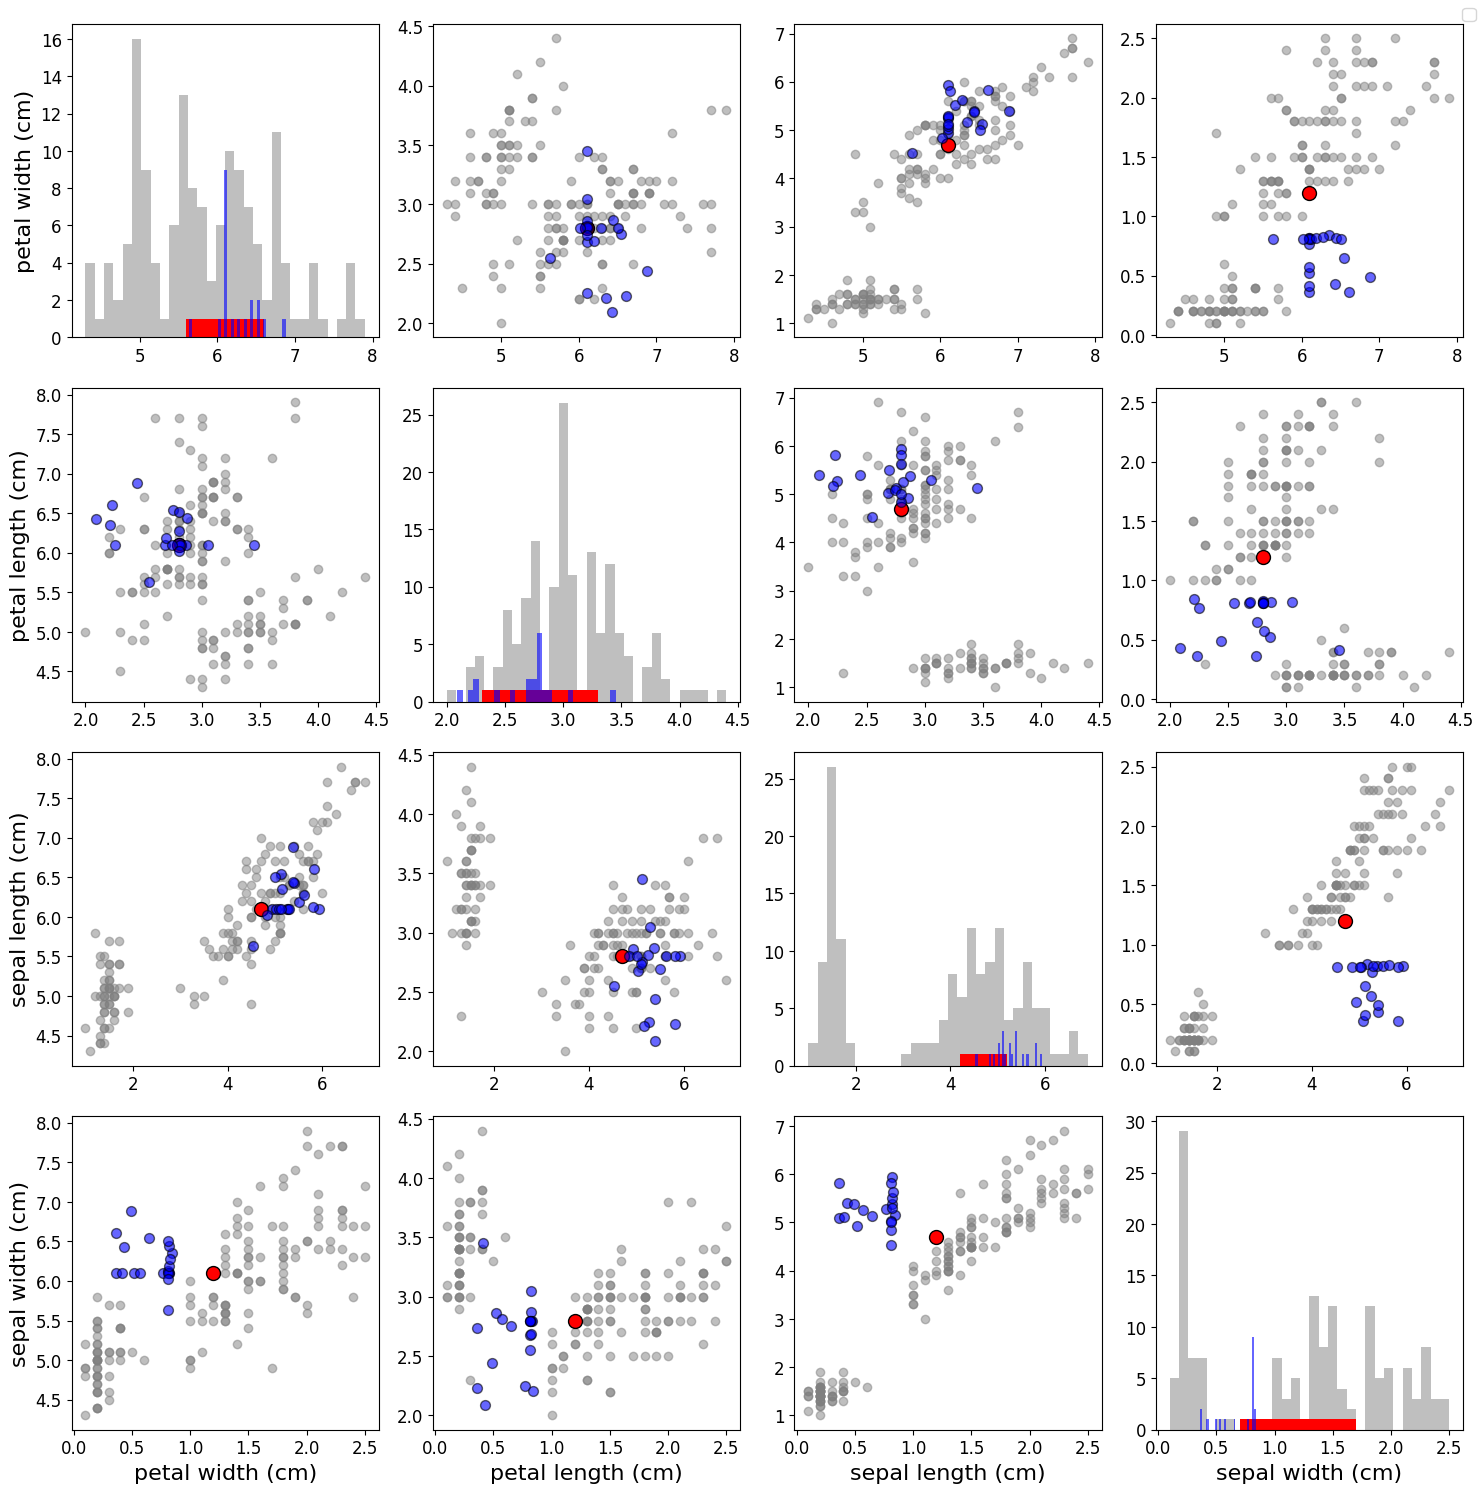

In [48]:
import itertools

sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
rules = ['no_change', 'non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df = []

for replicatons in range(20):
  # Iterate through each combination of rules
    #dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
    dict_non_actionable = {'sepal width (cm)': 'non_increasing'}

    # Create an instance of the CounterFactualDPG class
    cf_dpg = CounterFactualDPG(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df.append(cf_data)

counterfactuals_df = pd.DataFrame(counterfactuals_df)
# Displaying the DataFrame
print(counterfactuals_df)

plot_pairwise_with_counterfactual_df(model, X, y, sample, counterfactuals_df)